# Clustering & sub-clustering example

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from matplotlib.colors import ListedColormap

## 1.   Loading the Dataframe with pandas ->

In [2]:
pd.set_option("display.max.rows", 10)
pd.set_option("display.max.columns", 43)
missing_values = ["N/a", "na", np.nan] # Those are treated as 'NaN' as well

#? To get rid of the warning that shows up
dtype_dict = {
    '_id': int,
    'Area_of_Origin': str,
    'Building_Status': str,
    'Business_Impact': str,
    'Civilian_Casualties': float,
    'Count_of_Persons_Rescued': float,
    'Estimated_Dollar_Loss': float,
    'Estimated_Number_Of_Persons_Displaced': float,
    'Exposures': float,
    'Ext_agent_app_or_defer_time': str,
    'Extent_Of_Fire': str,
    'Final_Incident_Type': str,
    'Fire_Alarm_System_Impact_on_Evacuation': str,
    'Fire_Alarm_System_Operation': str,
    'Fire_Alarm_System_Presence': str,
    'Fire_Under_Control_Time': str,
    'Ignition_Source': str,
    'Incident_Number': str,
    'Incident_Station_Area': str,
    'Incident_Ward': float,
    'Initial_CAD_Event_Type': str,
    'Intersection': str,
    'Last_TFS_Unit_Clear_Time': str,
    'Latitude': float,
    'Level_Of_Origin': str,
    'Longitude': float,
    'Material_First_Ignited': str,
    'Method_Of_Fire_Control': str,
    'Number_of_responding_apparatus': float,
    'Number_of_responding_personnel': float,
    'Possible_Cause': str,
    'Property_Use': str,
    'Smoke_Alarm_at_Fire_Origin': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Failure': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Type': str,
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation': str,
    'Smoke_Spread': str,
    'Sprinkler_System_Operation': str,
    'Sprinkler_System_Presence': str,
    'Status_of_Fire_On_Arrival': str,
    'TFS_Alarm_Time': str,
    'TFS_Arrival_Time': str,
    'TFS_Firefighter_Casualties': float
}
###---
# url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64a26694-01dc-4ec3-aa87-ad8509604f50/resource/1e824947-d73b-4f48-9bac-7f7f3731"
# df = pd.read_csv(url, dtype=dtype_dict, na_values = missing_values)
df = pd.read_csv("Fire Incidents Data.csv", dtype=dtype_dict, na_values=missing_values)

#? Size: 29425 rows × 43 columns

## 2. Pre-processing / Cleaning the Data ->

In [3]:
# Remove only the rows that are all NaN (still 29425 rows × 43 columns, no row has only NaN)
df.dropna(how="all", inplace=True)
df.drop_duplicates(keep="first", inplace=True)

columns_to_drop = [
    'Exposures', 'Sprinkler_System_Operation', 'Sprinkler_System_Presence', 
    'Building_Status', 'Business_Impact', 'Civilian_Casualties', 
    'Count_of_Persons_Rescued', 'Estimated_Dollar_Loss', 
    'Estimated_Number_Of_Persons_Displaced', 
    'Extent_Of_Fire', 'Final_Incident_Type', 
    'Fire_Alarm_System_Impact_on_Evacuation', 'Incident_Number', 
    'Incident_Station_Area', 'Incident_Ward', 
    'Intersection', 'Level_Of_Origin', 'Property_Use', 
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 
    'Smoke_Spread', 'TFS_Firefighter_Casualties', 'Number_of_responding_personnel', 'Number_of_responding_apparatus', 'Method_Of_Fire_Control' 
]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop columns from DataFrame
df = df.drop(columns=columns_to_drop)

# Handling dates
datetime_columns = ['TFS_Alarm_Time', 'Fire_Under_Control_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

## 3. Preperation for k-means ->

In [4]:

#? Going to drop rows where Latitude and Longtitude are 0/NaN because I won't need them.
#* Longitude = Geographical length of nearest major or minor intersection in the ward of the incident
#* Latitude = Geographical width of the nearest major or minor intersection in the periphery of the incident

# Drop rows where Latitude and Longitude are 0/NaN
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]

## 2. Using the elbow method to find the optimal 'k' ->

In [5]:

#? Calculate total error for different numbers of clusters with K-Means
# err_total = []
# n_clusters = 10
# df_elbow = df[['Latitude', 'Longitude']]

# for i in range(1, n_clusters + 1):
#     kmeans = KMeans(n_clusters=i, random_state=0)
#     kmeans.fit(df_elbow)
#     err_total.append(kmeans.inertia_)

# # Plot elbow method
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(range(1, n_clusters + 1), err_total, linewidth=3, marker='o')
# ax.set_xlabel("Number of clusters", fontsize=14)
# ax.set_ylabel("Total error", fontsize=14)
# ax.set_title("Elbow Method", fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

- *Based on the Elbow method, I can see that the "elbow" is formed on the number 3 hence I am going to use k = 3.

## 3. Executing k-Means with `k = 3` ->

In [6]:
#? This Dataset contains Latitude values from [42 to 45] and Longitude from [-80 to -76] 
# 3 Clusters will be made, each one represating an area of Toronto

#? Based on google: 
# Downtown Toronto is approximate at: 43.6400 to 43.6544 Latitude / -79.3802 to -79.3802 Longtitude
# North York Toronto is approximate at: 43.65 to 43.80 Latitude / -79.40 to -79.30 Longtitude
# Scarborough Toronto is approximate at: 43.65 to 43.85 Latitude / -79.20 to -79.10 Longtitude
# So I will map each cluster with it's corresponding area name by creating another column

#---
kmeans = KMeans(n_clusters=3, random_state=0)
df['Locations_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])
centroids = kmeans.cluster_centers_

# Map clusters to location names
cluster_labels = {
    0: 'Downtown',
    1: 'North York',
    2: 'Scarborough'
}
df['Location_Name'] = df['Locations_Cluster'].map(cluster_labels)
#---

# # Plot clusters
# fig, ax = plt.subplots(figsize=(8, 6))
# customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
# scatter = ax.scatter(df['Longitude'], df['Latitude'], c=df['Locations_Cluster'], cmap=customcmap, s=80, alpha=0.5)
# ax.scatter(centroids[:, 1], centroids[:, 0], marker='s', s=200, c=[0, 1, 2], cmap=customcmap, edgecolor='black')
# ax.set_title('K-Means Fire Incidents in Toronto')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# handles, _ = scatter.legend_elements()
# labels = [cluster_labels[i] for i in range(3)]
# legend1 = ax.legend(handles, labels, title="Approximate Areas")
# ax.add_artist(legend1)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()


## 4. Creating Sub-Dataframes based on the Clusters ->

In [7]:
# Create sub-dataframes for each location
downtown_df = df[df['Location_Name'] == 'Downtown']
north_york_df = df[df['Location_Name'] == 'North York']
scarborough_df = df[df['Location_Name'] == 'Scarborough']

# Filter out '99 - Undetermined' cause
downtown_df = downtown_df[downtown_df['Possible_Cause'] != '99 - Undetermined']
north_york_df = north_york_df[north_york_df['Possible_Cause'] != '99 - Undetermined']
scarborough_df = scarborough_df[scarborough_df['Possible_Cause'] != '99 - Undetermined']

## 5. Sub Clustering 

In [8]:
cause_column = 'Possible_Cause'

# def calculate_inertia(data, datetime_columns, cause_column, max_clusters=10):
#     # Find the earliest time in the dataset
#     reference_time = pd.Timestamp('1970-01-01')
    
#     for col in datetime_columns:
#         earliest_time = data[col].min()
#         # Convert to duration since the earliest time in hours
#         data[col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
    
#     # Encode the possible cause column
#     le = LabelEncoder()
#     data[cause_column + '_encoded'] = le.fit_transform(data[cause_column])
    
#     # Combine all features for clustering
#     feature_columns = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']
    
#     # Handle missing values in feature columns
#     imputer = SimpleImputer(strategy='mean')
#     data_imputed = imputer.fit_transform(data[feature_columns])
    
#     # Calculate inertia for different number of clusters
#     inertia_values = []
#     for k in range(1, max_clusters + 1):
#         kmeans = KMeans(n_clusters=k, random_state=0)
#         kmeans.fit(data_imputed)
#         inertia_values.append(kmeans.inertia_)
    
#     return inertia_values

# # Calculate inertia for downtown_df
# inertia_downtown = calculate_inertia(downtown_df, datetime_columns, cause_column)

# # Calculate inertia for north_york_df
# inertia_north_york = calculate_inertia(north_york_df, datetime_columns, cause_column)

# # Calculate inertia for scarborough_df
# inertia_scarborough = calculate_inertia(scarborough_df, datetime_columns, cause_column)

# # Plotting the elbow curves
# fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
# fig.suptitle('Elbow Method for Optimal k')

# axes[0].plot(range(1, len(inertia_downtown) + 1), inertia_downtown, marker='o')
# axes[0].set_title('Downtown')
# axes[0].set_xlabel('Number of clusters')
# axes[0].set_ylabel('Inertia')

# axes[1].plot(range(1, len(inertia_north_york) + 1), inertia_north_york, marker='o')
# axes[1].set_title('North York')
# axes[1].set_xlabel('Number of clusters')

# axes[2].plot(range(1, len(inertia_scarborough) + 1), inertia_scarborough, marker='o')
# axes[2].set_title('Scarborough')
# axes[2].set_xlabel('Number of clusters')

# plt.tight_layout()
# plt.show()

In [9]:
def perform_kmeans_clustering(data, datetime_columns, cause_column, k):
    # Find the earliest time in the dataset
    reference_time = pd.Timestamp('1970-01-01')
    
    for col in datetime_columns:
        earliest_time = data[col].min()
        # Convert to duration since the earliest time in hours
        data[col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
    
    # Encode the possible cause column
    le = LabelEncoder()
    data[cause_column + '_encoded'] = le.fit_transform(data[cause_column])
    
    # Combine all features for clustering
    feature_columns = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']
    
    # Handle missing values in feature columns
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data[feature_columns])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(data_imputed)
    
    return data, kmeans.cluster_centers_

cause_column = 'Possible_Cause'

# Example of usage for one sub-dataframe (e.g., downtown_df)
downtown_clustered, downtown_centers = perform_kmeans_clustering(downtown_df, datetime_columns, cause_column, 3)
north_york_clustered, north_york_centers = perform_kmeans_clustering(north_york_df, datetime_columns, cause_column, 3)
scarborough_clustered, scarborough_centers = perform_kmeans_clustering(scarborough_df, datetime_columns, cause_column, 3)

# Calculate the metrics for each sub-dataframe
def calculate_response_metrics(df):
    df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds() / 3600
    df['Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600
    df['Clear_Time'] = (df['Last_TFS_Unit_Clear_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600

    return df

downtown_df = calculate_response_metrics(downtown_df)
north_york_df = calculate_response_metrics(north_york_df)
scarborough_df = calculate_response_metrics(scarborough_df)

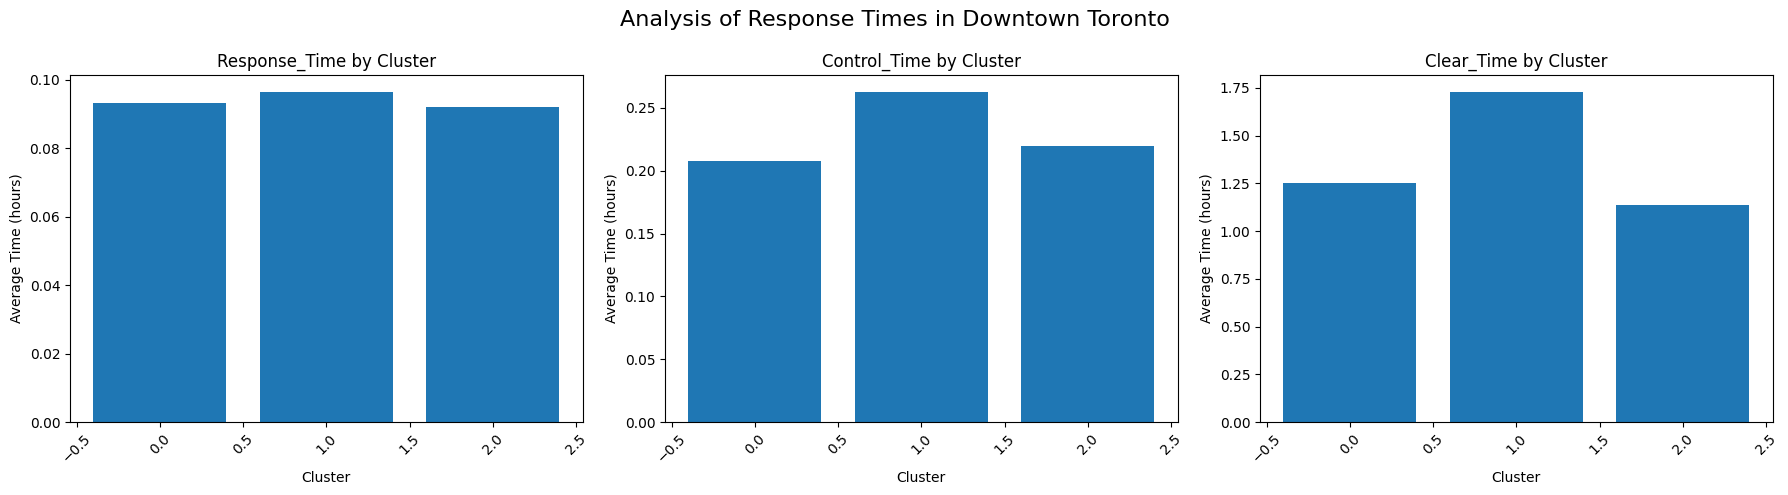

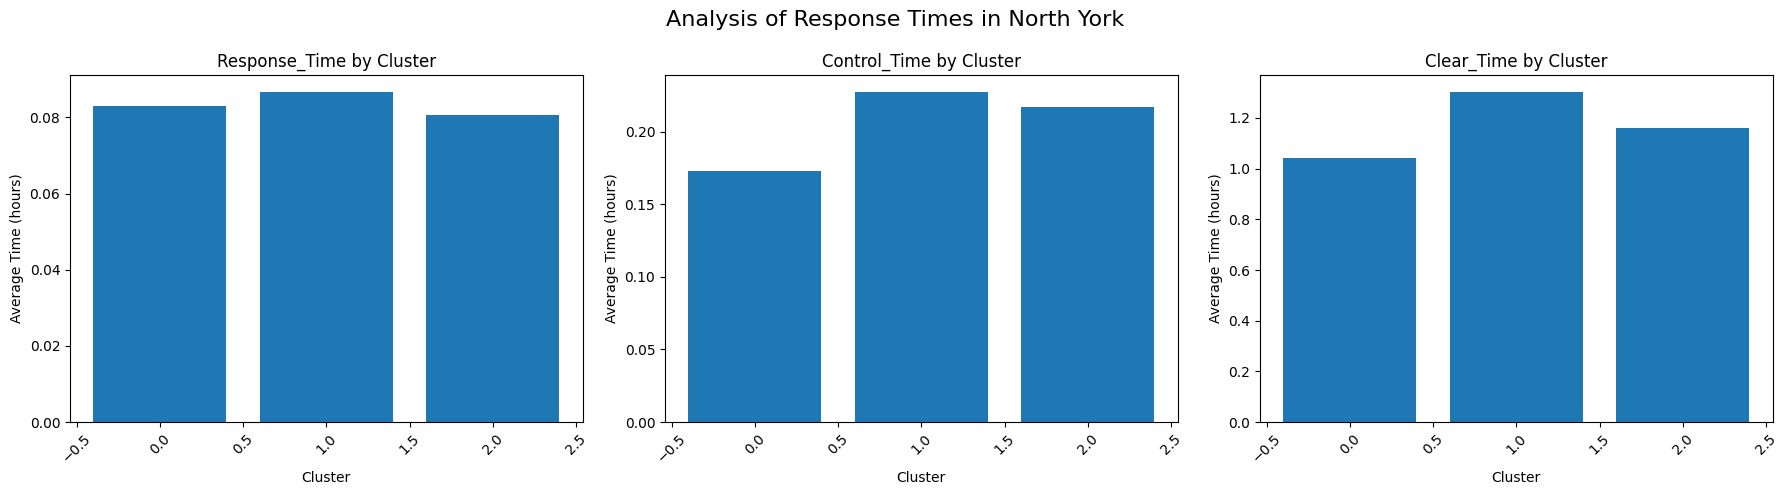

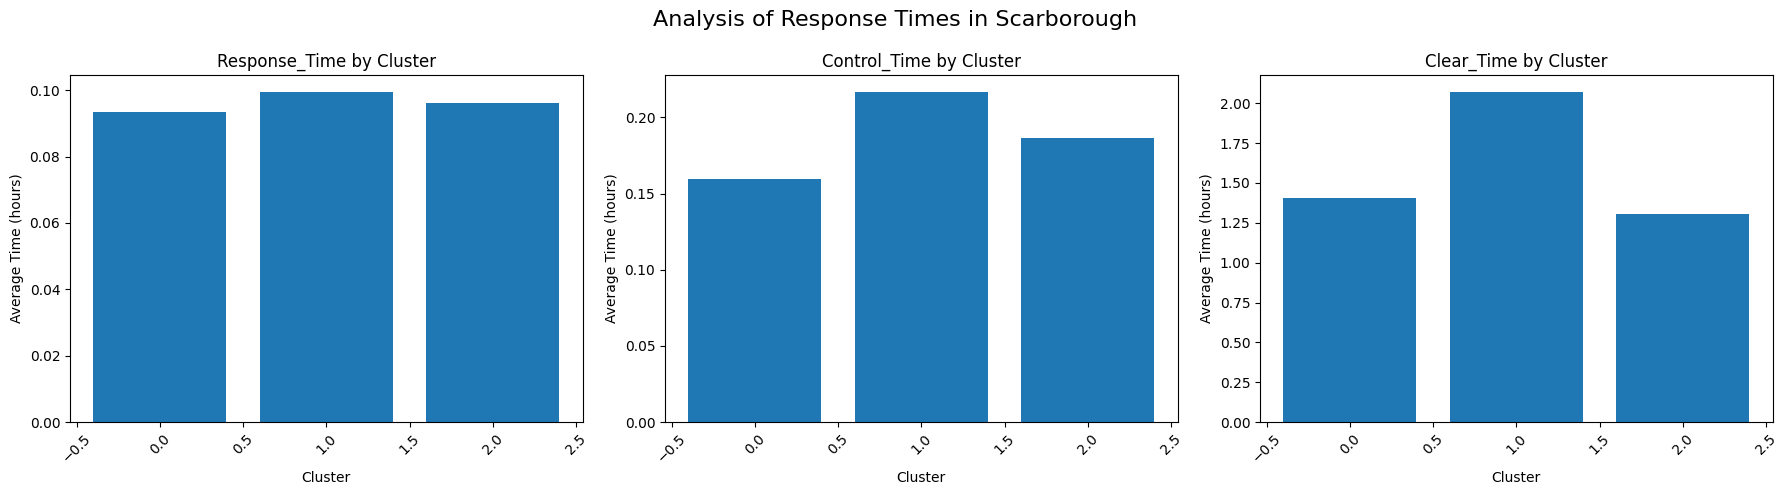

In [10]:
def plot_cause_analysis(df, location_name, cause_column):
    # Example of specifying colors manually
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
        '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
        '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
        '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
        '#5254a3', '#637939', '#8ca252', '#bd9e39', '#8c6d31']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(f'Analysis of {cause_column} in {location_name}', fontsize=16)

    cause_counts = df.groupby('Cluster')[cause_column].value_counts().unstack().fillna(0)
    cause_counts.plot(kind='bar', stacked=True, ax=ax, color=colors)
    
    ax.set_title(f'{cause_column} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(title=cause_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


def plot_response_time_analysis(df, location_name):
    metrics = ['Response_Time', 'Control_Time', 'Clear_Time']
    fig, axs = plt.subplots(1, len(metrics), figsize=(18, 5))
    fig.suptitle(f'Analysis of Response Times in {location_name}', fontsize=16)

    for i, metric in enumerate(metrics):
        avg_time = df.groupby('Cluster')[metric].mean()
        ax = axs[i]
        ax.bar(avg_time.index, avg_time.values)
        ax.set_title(f'{metric} by Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Average Time (hours)')
        ax.tick_params(axis='x', labelrotation=45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Plot the response time analysis for each sub-dataframe
plot_response_time_analysis(downtown_df, 'Downtown Toronto')
plot_response_time_analysis(north_york_df, 'North York')
plot_response_time_analysis(scarborough_df, 'Scarborough')

  Cluster Response_Time           Control_Time           Clear_Time            \
                   mean       std         mean       std       mean       std   
0       0      0.093107  0.029224     0.207612  0.559741   1.250276  2.401249   
1       1      0.096573  0.034376     0.262902  0.755357   1.731339  4.318350   
2       2      0.092060  0.032307     0.219436  0.793573   1.135563  2.704680   
3       0      0.083031  0.206547     0.172771  0.350819   1.042700  1.836481   
4       1      0.086807  0.036403     0.227533  0.640660   1.304067  3.765252   
5       2      0.080573  0.028445     0.217002  0.471440   1.158288  2.679571   
6       0      0.093314  0.028914     0.159578  0.303895   1.404318  3.237169   
7       1      0.099603  0.040915     0.217032  0.364585   2.072712  4.851807   
8       2      0.096047  0.114882     0.186232  0.323207   1.303956  3.020747   

           Location  
                     
0  Downtown Toronto  
1  Downtown Toronto  
2  Downtown Toronto 

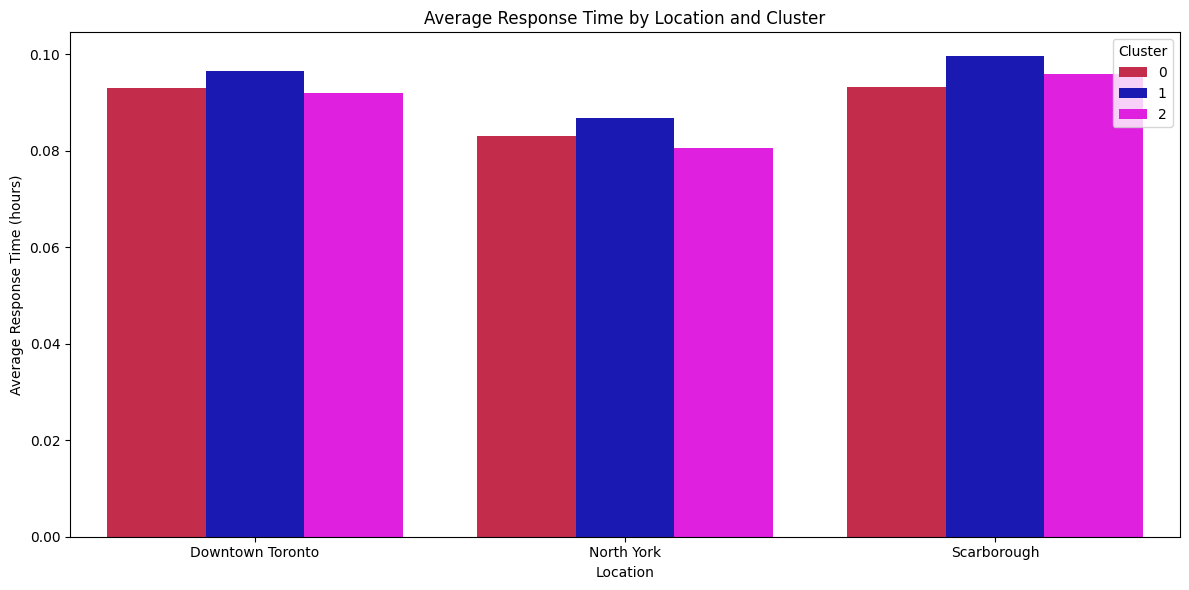

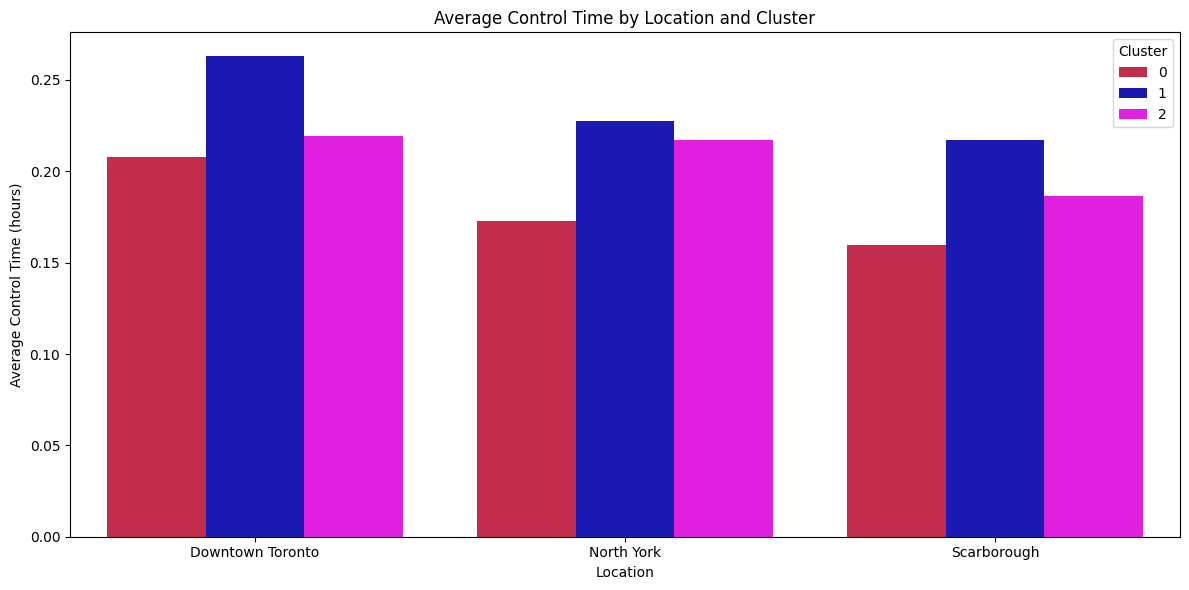

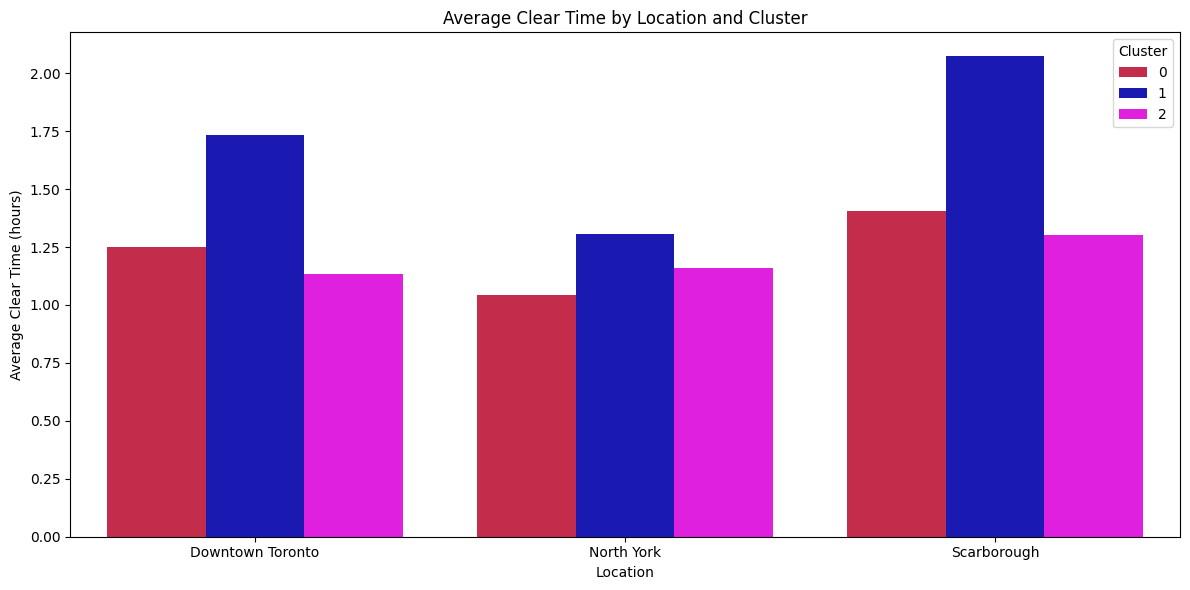

In [13]:
def calculate_summary_statistics(df, location_name):
    metrics = ['Response_Time', 'Control_Time', 'Clear_Time']
    summary_stats = df.groupby('Cluster')[metrics].agg(['mean', 'std']).reset_index()
    summary_stats['Location'] = location_name
    return summary_stats

downtown_stats = calculate_summary_statistics(downtown_df, 'Downtown Toronto')
north_york_stats = calculate_summary_statistics(north_york_df, 'North York')
scarborough_stats = calculate_summary_statistics(scarborough_df, 'Scarborough')

all_stats = pd.concat([downtown_stats, north_york_stats, scarborough_stats], ignore_index=True)
print(all_stats)


def plot_summary_statistics(stats, metric):
    customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=stats, x='Location', y=(metric, 'mean'), hue='Cluster', ax=ax, palette=customcmap.colors)
    ax.set_title(f'Average {metric.replace("_", " ")} by Location and Cluster')
    ax.set_xlabel('Location')
    ax.set_ylabel(f'Average {metric.replace("_", " ")} (hours)')
    ax.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# Plotting for each metric
plot_summary_statistics(all_stats, 'Response_Time')
plot_summary_statistics(all_stats, 'Control_Time')
plot_summary_statistics(all_stats, 'Clear_Time')

Sample analysis on the Possible cause (No clustering yet) -> 